In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

In [72]:
snapshots = pd.read_csv('../data/robotanik/task639.csv')
snapshots.trace = snapshots.trace.map(lambda t: tuple(eval(t)))  # replace list by tuple to make it hashable
print(len(snapshots))
snapshots.head()

11683


,user,game,step,time,correct,code,trace
0,2,1,1,31,False,_FbL_1|||||,"((5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5,..."
1,2,1,2,25,False,_FbLr2_1|_FbR_2||||,"((5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5,..."
2,2,1,3,15,False,_FbLr2_1|_RbFbR_2||||,"((5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5,..."
3,2,1,4,10,False,_FbLr2_1|_R_FbR_2||||,"((5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5,..."
4,2,1,5,9,False,_FbLr2_1|rR_FbR_2||||,"((5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5,..."


## Unique traces

In [73]:
traces = snapshots.trace.value_counts()
print('number of unique traces:', len(traces))
# traces[traces >= 50].plot.barh()

number of unique traces: 259


In [151]:
# there are many more unique codes, but in this analysis, we will only focus on traces
codes = snapshots.code.value_counts()
print('number of unique codes:', len(codes))

number of unique codes: 5509


In [201]:
# group snapshots by traces and for each trace compute its count (in games/for users)
# and some addition info (if correct, median log time, median step)

#def _snapshot_group_stats(group):
#snapshots.groupby(['trace']).apply(_snapshot_group_stats)

traces = snapshots.groupby('trace', as_index=False)\
    .agg({'user': 'count', 'step': 'median', 'correct' : 'mean', 'time' : 'median'})
traces = traces.sort_values(by='user', ascending=False)  #.head(30)
traces = traces.reset_index().drop(['index'], axis=1)
traces.head()

,trace,step,correct,time,user
0,"((5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5,...",3.0,0.492692,11.0,2121
1,"((5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5,...",4.0,0.000000,19.0,1904
2,"((5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5,...",4.0,0.000000,19.0,1457
3,"((5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5,...",3.0,0.000000,27.0,1121
4,"((5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5,...",6.0,0.000000,21.0,910


## t-SNE

In [172]:
def jaccard_distance(a, b):
    """ Distance between two sets

    >>> jaccard_distance({1, 2}, {1, 2})
    0.0
    >>> jaccard_distance({1, 2}, {3, 4})
    1.0
    >>> jaccard_distance({1, 2, 3}, {1, 2, 4, 5})
    0.6
    """
    setA = set(a)
    setB = set(b)
    intersection_size = len(setA & setB)
    union_size = len(setA | setB)
    distance = (1 - intersection_size / union_size) if union_size > 0 else 0.
    return distance

In [173]:
n = len(traces)
distances = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        distances[i,j] = jaccard_distance(traces.trace[i], traces.trace[j])

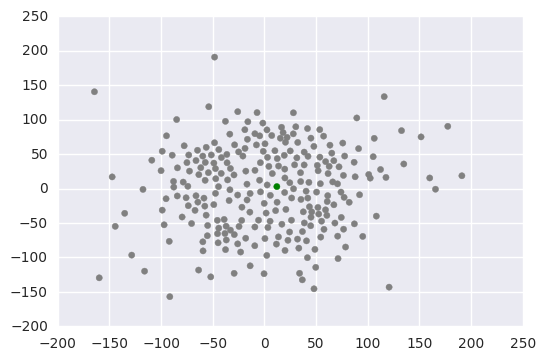

In [194]:
# we have only a few points, so we need to be careful not to overshoot the perprexity
tsne = TSNE(perplexity=20, learning_rate=1000, metric='precomputed')
emb = pd.DataFrame(tsne.fit_transform(distances))
plt.scatter(emb[0], emb[1], color=traces.correct.map(lambda c: 'green' if c > 0.4 else 'gray'))

In [202]:
traces['x'] = pd.Series(emb[0], index=traces.index)
traces['y'] = pd.Series(emb[1], index=traces.index)

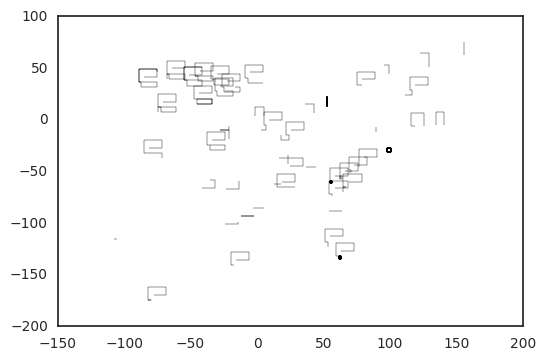

In [214]:
plt.style.use('seaborn-white')
s = pd.DataFrame(traces[:50])
fig, ax = plt.subplots()
for i in range(len(s)):
    ax.scatter(s.x[i], s.y[i], c='none', marker=None, verts=list((x,-y) for (y, x) in s.trace[i]), s=2000)
plt.savefig('g.pdf')

## With median time and step as axes

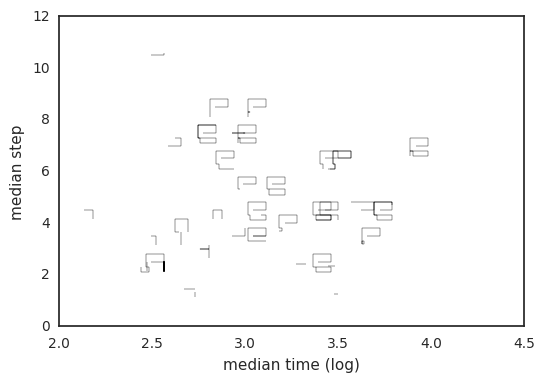

In [213]:
s = pd.DataFrame(traces[:40])
fig, ax = plt.subplots()
ax.set_xlabel('median time (log)')
ax.set_ylabel('median step')
for i in range(len(s)):
    ax.scatter(np.log(s.time[i]), s.step[i], c='none', marker=None, verts=list((x,-y) for (y, x) in s.trace[i]), s=2000)